# Specific Dynamic Feature improving the performance of a model

## Init

In [2]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\new-peak-project\src


In [3]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [4]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [5]:
import os 

### parameters 

notebook_name = 'exp1_dynamic_feature' # name of the notebook

## Generation of ground truth model 

model_name = 'v3_small_model_52'
o_random_seed = 4
p_random_seed = 4
no_observable_species = 5
no_feedback_regulations = 2
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.7, 1.3)


## Simulation parameters 

simulation_time = 500 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

# Engineering Feature Data 

data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp1_dynamic_feature_4_50/


## Analysis

### Virtual Cell Creation

In [6]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(4, 5, 2, verbose=0)
drug_0 = Drug('D0', 500, 5000)
drug_0.add_regulation('A0', 'down')
drug_0.add_regulation('A1', 'down')
drug_0.add_regulation('A2', 'down')
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('C', 'A1'), ('B0', 'A2'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2')]
Regulation Types: ['up', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2'], ['down', 'down', 'down'])

Feedback: [(('C', 'A1'), 'up'), (('B0', 'A2'), 'down')]


In [7]:
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=4, verbose=0)
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

In [8]:
print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; J1_Vmax*A0/(J1_Km*(1+D0*J1_Kic0) + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+Cp*J3_Kw0)*A1/(J3_Km*(1+D0*J3_Kic0) + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; J5_Vmax*A2/(J5_Km*(1+B0p*J5_Kic0+D0*J5_Kic1) + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; J7_Vmax*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; J9_Vmax*A4/(J9_Km + A4)
J10: B0p -> B0; J10_Vmax*B0p/(J10_Km + B0p)
J11: B0 -> B0p; (J11_Vmax+A0p*J11_Kw0)*B0/(J11_Km + B0)
J12: B1p -> B1; J12_Vmax*B1p/(J12_Km + B1p)
J13: B1 -> B1p; (J13_Vmax+A1p*J13_Kw0)*B1/(J13_Km + B1)
J14: B2p -> B2; J14_Vmax*B2p/(J14_Km + B2p)
J15: B2 -> B2p; (J15_Vmax+A2p*J15_Kw0)*B2/(J15_Km + B2)
J16: B3p -> B3; J16_Vmax*B3p/(J16_Km + B3p)
J17: B3 -> B3p; (J17_Vmax+A3p*J17_Kw0)*B3/(J17_Km + B3)
J18: B4p -> B4; J18_Vmax*B4p/(J18_Km + B4p)
J19: B4 -> B4p; (J19_Vmax+A4p*J19_Kw0)*B4/(J19_Km + B4)
J20: C ->

In [9]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

result = solver.simulate(0, 1000, 100)
result

,time,A0p,A0,A1p,A1,Cp,A2p,A2,B0p,A3p,...,B0,B1p,B1,B2p,B2,B3p,B3,B4p,B4,C
0,0.00000,0.000000,4494.000000,0.000000,154.000000,0.000000,0.000000,3447.000000,0.000000,0.000000,...,2966.000000,0.000000,753.000000,0.000000,2644.000000,0.000000,1689.000000,0.000000,426.000000,100.000000
1,10.10101,0.788136,4493.211864,3.799921,150.200079,9.264363,49.991849,3397.008151,18.660909,63.103802,...,2947.339091,24.083436,728.916564,228.773779,2415.226221,85.576238,1603.423762,423.956439,2.043561,90.735637
2,20.20202,1.046907,4492.953093,3.456608,150.543392,6.697752,82.788122,3364.211878,22.362870,90.784056,...,2943.637130,48.360502,704.639498,620.672521,2023.327479,197.185925,1491.814075,424.813125,1.186875,93.302248
3,30.30303,1.131930,4492.868070,2.974359,151.025641,5.173779,110.542669,3336.457331,23.290543,105.418807,...,2942.709457,69.640170,683.359830,1127.919347,1516.080653,290.283274,1398.716726,425.080809,0.919191,94.826221
4,40.40404,1.159872,4492.840128,2.674896,151.325104,4.262730,135.307828,3311.692172,23.557172,113.693336,...,2942.442828,88.513460,664.486540,1704.667045,939.332955,361.865887,1327.134113,425.206228,0.793772,95.737270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,0.007523,4493.992477,0.031432,153.968568,25.106081,5.324461,3441.675539,19.418308,125.752279,...,2946.581692,299.962499,453.037501,147.908864,2496.091136,541.971151,1147.028849,425.387670,0.612330,74.893919
96,969.69697,0.007523,4493.992477,0.031641,153.968359,25.292852,4.961298,3442.038702,19.418308,125.752279,...,2946.581692,299.680076,453.319924,140.598914,2503.401086,541.971151,1147.028849,425.387670,0.612330,74.707148
97,979.79798,0.007523,4493.992477,0.031811,153.968189,25.446175,4.644639,3442.355361,19.418308,125.752279,...,2946.581692,299.412943,453.587057,134.646979,2509.353021,541.971151,1147.028849,425.387670,0.612330,74.553825
98,989.89899,0.007523,4493.992477,0.031952,153.968048,25.573923,4.368584,3442.631416,19.418308,125.752279,...,2946.581692,299.160243,453.839757,129.720271,2514.279729,541.971151,1147.028849,425.387670,0.612330,74.426077


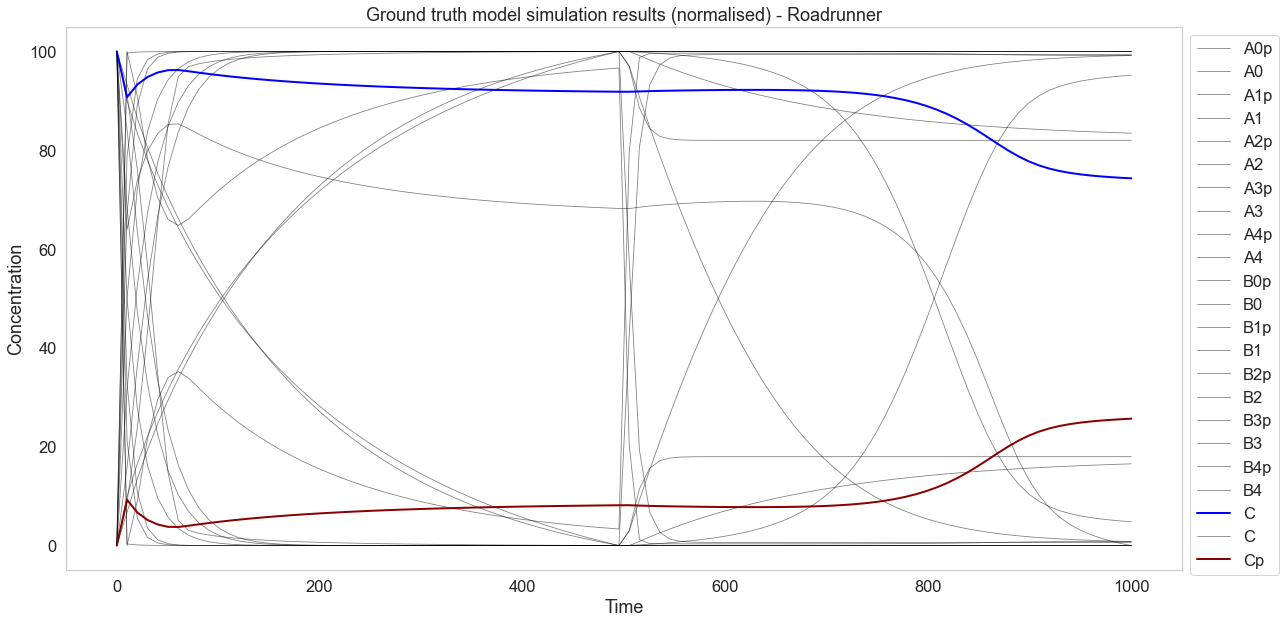

In [10]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Generate synthetic 'omics-like' data

In [11]:
from models.SyntheticGen import generate_feature_data, generate_target_data

feature_data = generate_feature_data(model_drug_spec, G0_d.get_state_variables(), feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data(model_drug_spec, solver, feature_data, {'start': 0, 'end': 1000, 'points': 100})


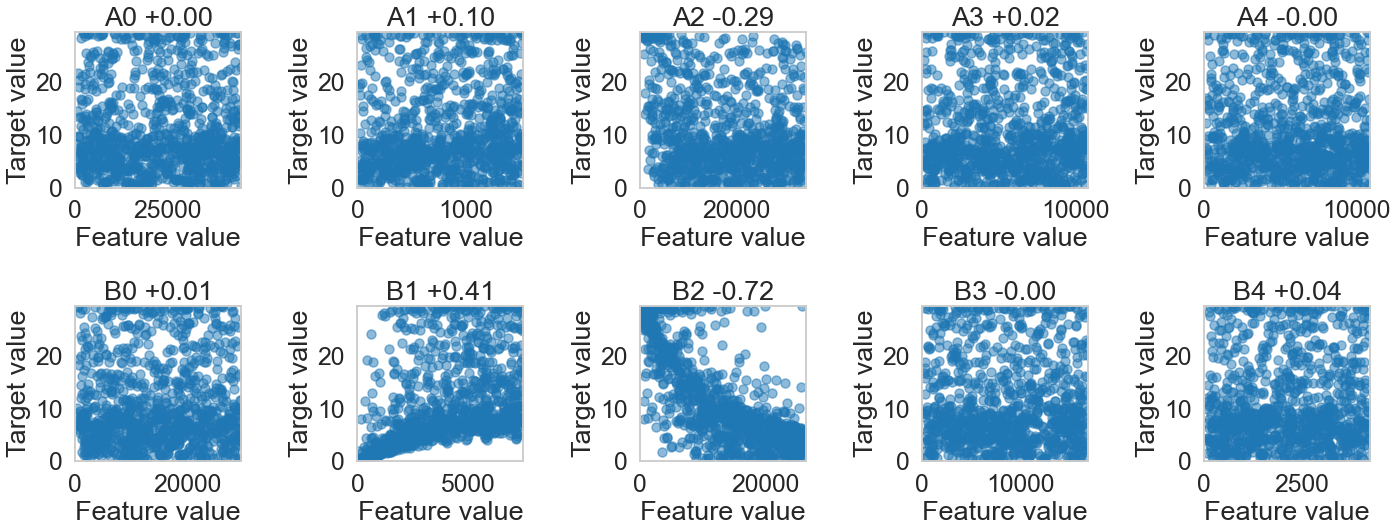

In [12]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

# make a subplot based on the size of feature_data, have five columns and as many rows as needed
n_features = len(feature_data.columns)
n_rows = int(n_features / 5) 
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()
# plot each feature in a separate subplot
for i, feature in enumerate(feature_data.columns):
    # plot the feature data and target data
    corr, _ = pearsonr(feature_data[feature], target_data)
    axs[i].scatter(feature_data[feature], target_data, alpha=0.5)
    corr_str = str(corr)
    # polish the correlation string to 2 decimal places, remove [ 
    # and ] and add a + sign if the correlation is positive
    if corr > 0:
        corr_str = '+' + corr_str[1:5]
    else:
        corr_str = corr_str[1:6]
        
    axs[i].set_title(f'{feature} {corr_str}')
    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

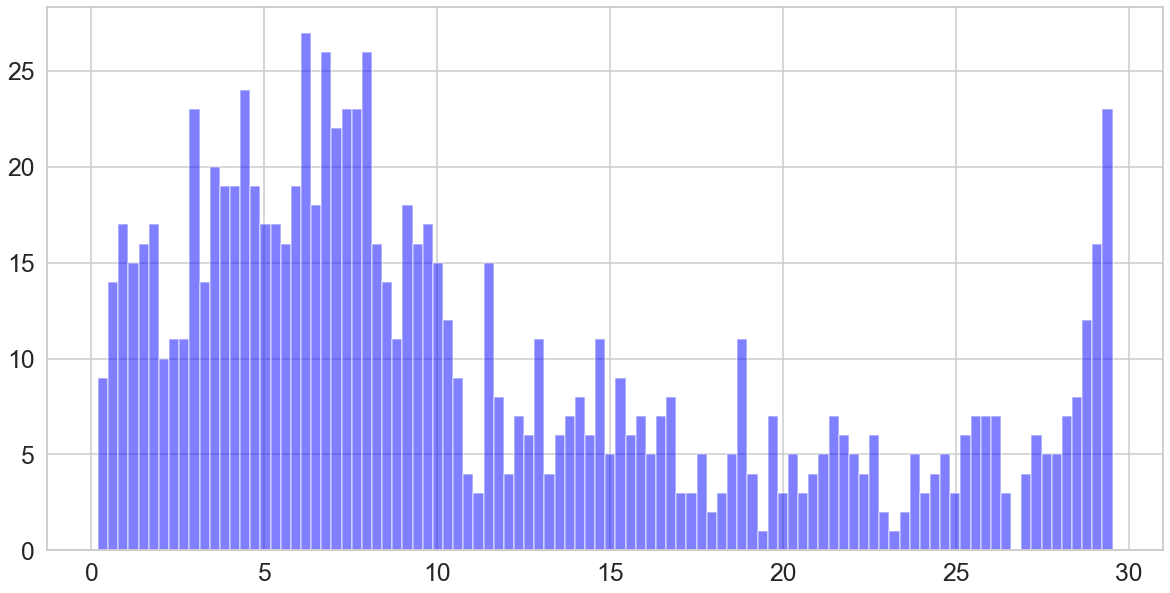

In [13]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


In [14]:
new_model_spec, new_model, reg_deleted = systematic_edge_pruning(model_drug_spec, G0_d, 2, o_random_seed)
print(reg_deleted)

print(len(model_drug_spec.get_regulations()))
print(len(new_model_spec.get_regulations()))

[(('B1', 'C'), 'down'), (('B0', 'C'), 'up')]
15
13


In [15]:
new_solver = RoadrunnerSolver()
new_solver.compile(new_model.get_sbml_model())
new_result = new_solver.simulate(0, 1000, 100)

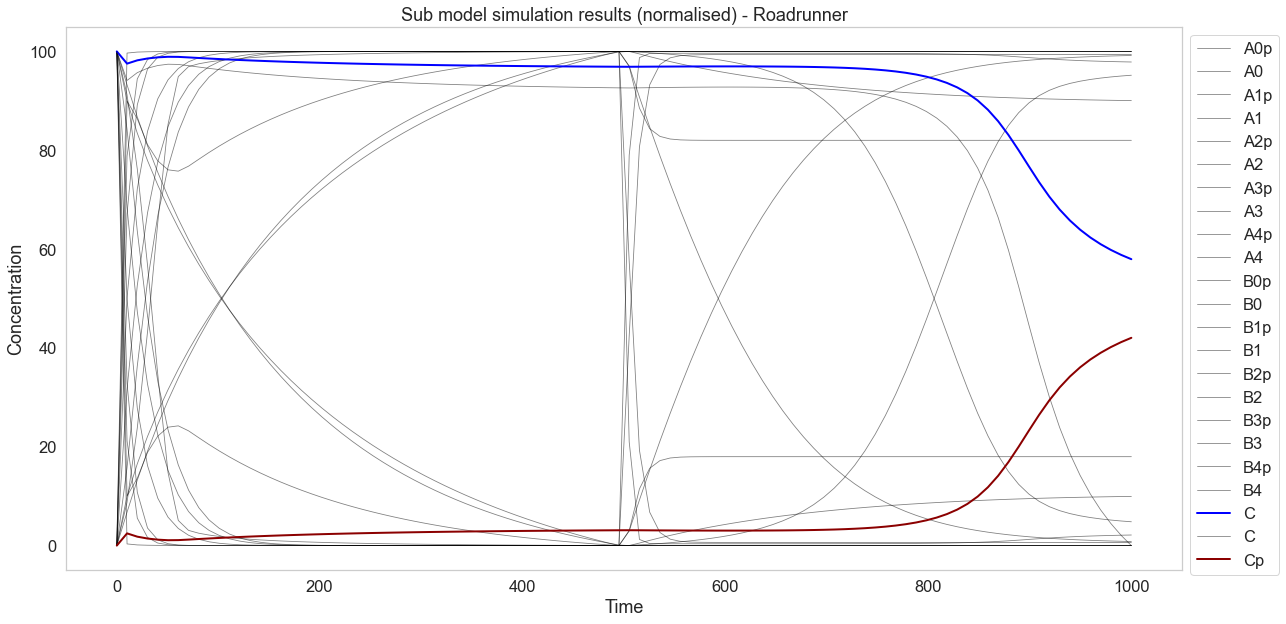

In [16]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()
result = new_result

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Sub model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Simulation / Extract dynamic feature data

In [17]:
from models.SyntheticGen import generate_model_timecourse_data 

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data(new_model_spec, 
                                                  new_solver, 
                                                  feature_data, 
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all')


In [18]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = new_model_spec.A_species + new_model_spec.B_species + new_model_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

In [19]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species)

100%|██████████| 1000/1000 [00:11<00:00, 85.28it/s]


In [20]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [21]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

### Machine Learning Training

In [23]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,feature_data,19.345690,0.688847,0.833572,6.296317e-53
1,Linear Regression,feature_data,18.161851,0.749536,0.866115,1.527619e-61
2,Linear Regression,feature_data,20.022107,0.740155,0.861069,4.581430e-60
3,Linear Regression,feature_data,19.549350,0.737703,0.861378,3.733949e-60
4,Linear Regression,feature_data,18.475329,0.760442,0.874862,2.992373e-64
...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,2.118040,0.967256,0.983690,1.752415e-149
246,Neural Network,combined_dyn_data,3.420896,0.950673,0.975532,3.220969e-132
247,Neural Network,combined_dyn_data,0.864817,0.987432,0.993699,3.676938e-190
248,Neural Network,combined_dyn_data,0.773382,0.989245,0.994608,7.660730e-197


In [24]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: C:\Users\dawson\Documents\Google Drive\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp1_dynamic_feature_4_50/metric_df.pkl


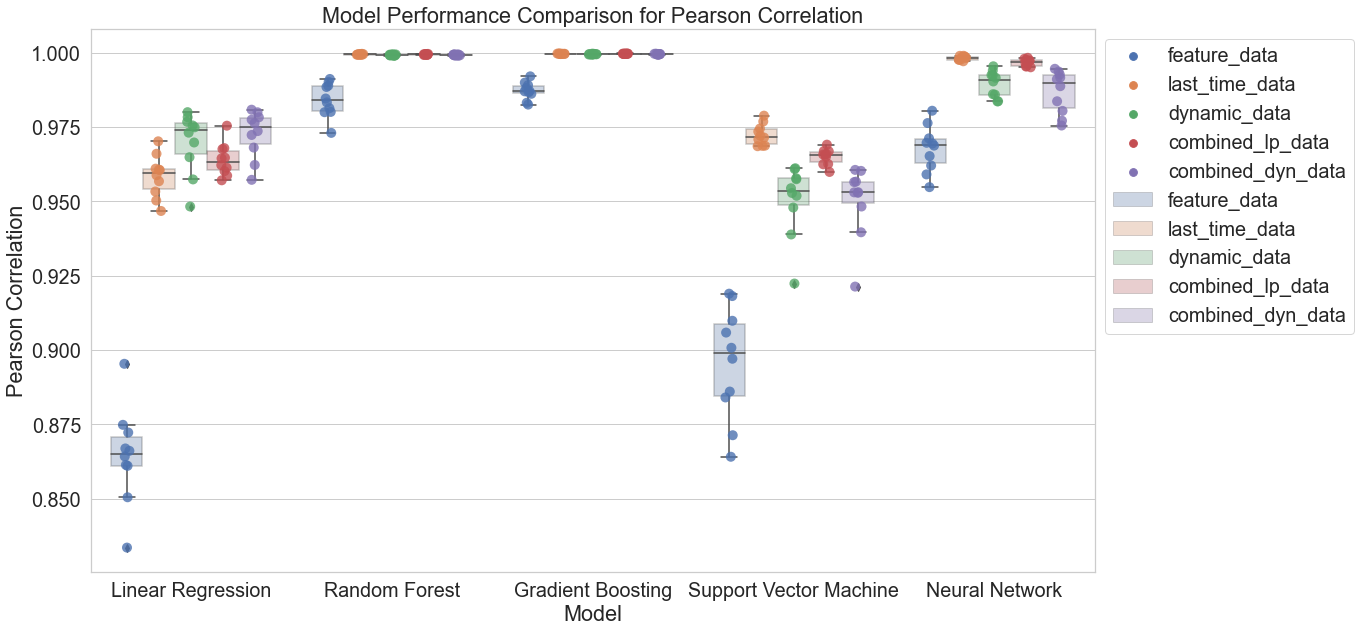

In [28]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

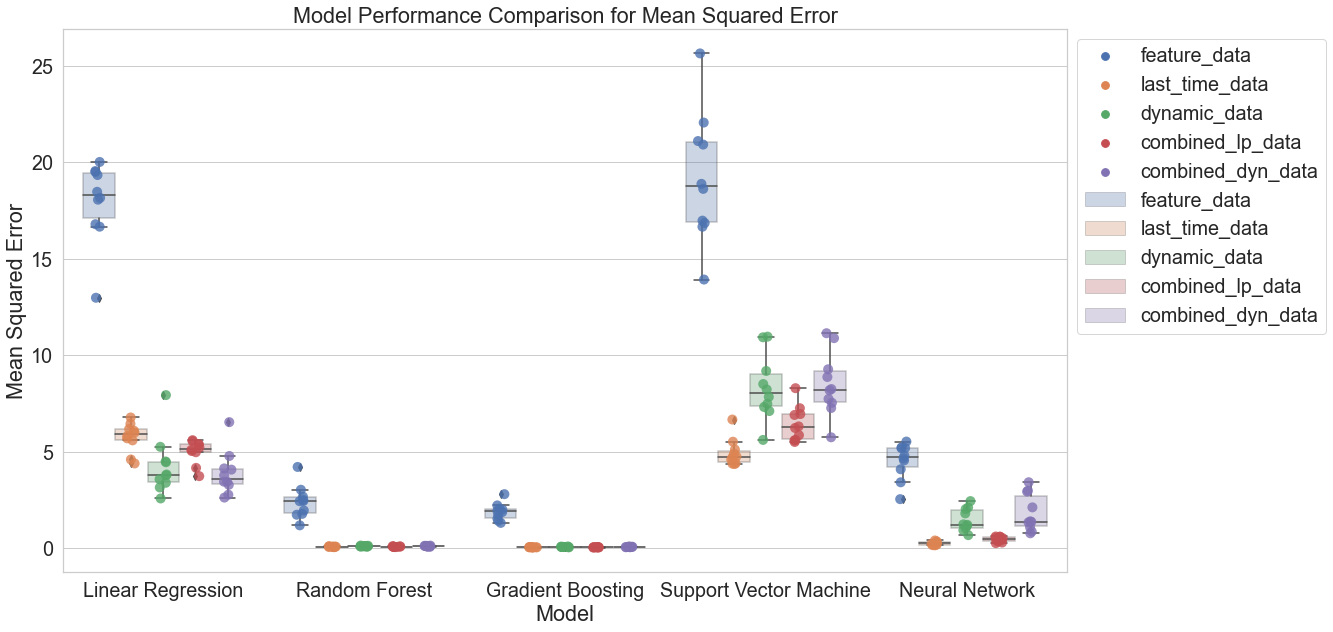

In [27]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()